# Trabalho #2 - Função de custo e camada customizada

Nesse trabalho você vai criar e treinar uma RNA com camada e função de custo customizadas e realizar o treinamento customizado da mesma usando a função `GradienteTape()`.

O problema que será resolvido consiste na classificação "one-shot" de vestuários do conjunto Fashion-MINIST.

Esse trabaalho é baseado em "Hadsell-et-al., Dimensionality Reduction by Learning an Invariant Mapping", (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf).

## Coloque o seu nome aqui:

Nome: Bruno Rodrigues Silva

### Importação das bilbiotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.5.0


## 2. Classificação "one-shot"

Para apresentar um exemplo realista de uso de uma função de custo e uma camada customizada, você vai desenvolver um modelo para resolver uma tarefa de classificação "one-shot" usando uma RNA siamesa e a função de custo contrastante, que será vista mais adiante nesse notebook.

Esse tipo de modelo é usado para identificação de pessoas pela face e para classificação multiclasse quando se tem poucos exemplos de cada classe. Nota-se que classificação multiclasse usando o método "one-shot" foi visto na disciplina de Redes Convolucionais.

Na aula de reconhecimento de pessoas pela face foi visto com detalhes o uso da função de custo tripla, que é treinada com uma rede siamesa. Naquela aula também foi visto o método de usar somente duas imagens para identificar faces, mas não com detalhes.

Na Figura 1 é apresentado um esquema da rede siamesa utilizada nesse tipo de tarefa. Esse tipo de modelo é utilizado para verificar se duas imagens (ou dois vetores) pertencem ou não à mesma classe.


<img src='Classificação_one_shot.png'>
<center>Figura 1 - Esquema de modelo para classificação one-shot com função de custo contrastante.</center>
<br>

A ideia desse modelo é usar uma rede neural para gerar os vetores de características das duas imagens de forma que: 

1. Se as duas imagens forem similares, então os vetores de caracteríticas devem ser similares; e 
2. Se as duas imagens forem diferentes, então os vetores de características devem ser diferentes.

Nesse modelo as duas imagens são processadas em paralelo pela mesma rede, gerando dois vetores de características. A distância Euclidiana entre os dois vetores é calculada e as duas imagens são classificadas em função da distância entre elas da seguinte forma:

- Se a distância for maior do que um limiar pré-selecionado, então, as imagens são consideradas de classes diferentes;
- Se a distância for menor do que o limiar, então as imagens são consideradas da mesma classe.

Esse método de classificação "one-shot" foi criado por: R. Hadrell, S. Chopra e Y. Lecun, "Dimensionality reduction by learning an invariant mapping", 2006.

Para treinar um modelo desse tipo é utilizada a função de custo contrastante, cujo nome vem de contraste.

## 3. Carregar e pré-processar dados


### 3.1 Carregar dados

Os dados utilizado nesse exemplo é conjunto de vestuário da Fashion-MINIST, que pode ser carregado diretamento de Keras.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print('Dimensão dos dados de entrada de treinamento =', x_train.shape)
print('Dimensão dos dados de entrada de teste =', x_test.shape)
print('Dimensão dos dados de saída de treinamento =', y_train.shape)
print('Dimensão dos dados de saída de teste =', y_test.shape)

Dimensão dos dados de entrada de treinamento = (60000, 28, 28)
Dimensão dos dados de entrada de teste = (10000, 28, 28)
Dimensão dos dados de saída de treinamento = (60000,)
Dimensão dos dados de saída de teste = (10000,)


### 3.2 Processar dados

Como as imagens do conjunto de dígitos MNIST são pequenas e em tons de cinza, para simplificar vamos transformar as imagens em vetores e usar uma rede com camadas densas.

Dessa forma é necessário redimensionar as imagens para torná-las vetores. Além disso, os pixels das imagens devem ser normalizados para srem valores reais entre 0 e 1.

In [3]:
# Número total de pixels nas imagens
nx = x_train.shape[1]*x_train.shape[2]

# Redimensionamento e normalização das das imagens
x_train_flat = np.reshape(x_train, (x_train.shape[0], nx))/255.
x_test_flat = np.reshape(x_test, (x_test.shape[0], nx))/255.

print('Dimensão dos dados de entrada de treinamento =', x_train_flat.shape)
print('Dimensão dos dados de entrada de teste =', x_test_flat.shape)

Dimensão dos dados de entrada de treinamento = (60000, 784)
Dimensão dos dados de entrada de teste = (10000, 784)


#### Gráficos de alguns exemplos

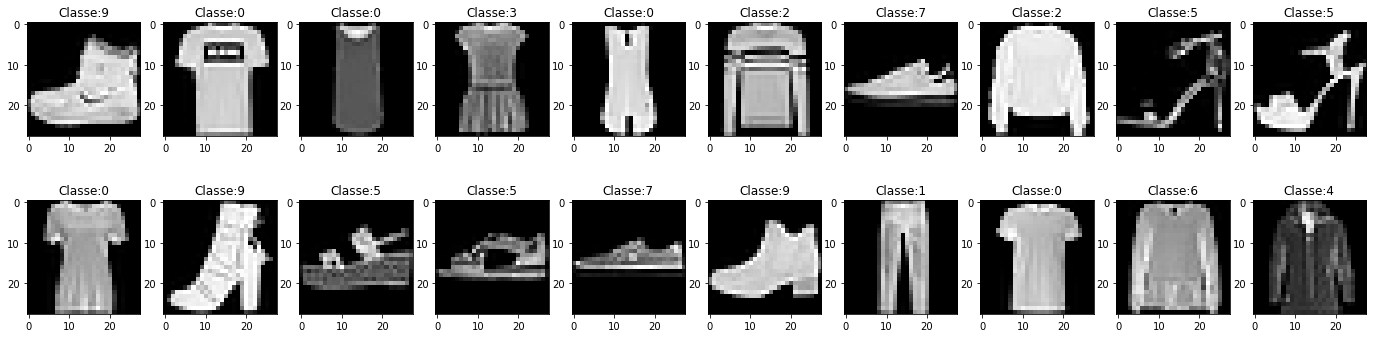

In [4]:
fig, axs = plt.subplots(2,10,figsize=(24,6))
index = 0
for i in range(2):
    for j in range(10):
        axs[i,j].imshow(x_train[index], cmap='gray', vmin=0, vmax=255)
        axs[i,j].set_title('Classe:' + str(y_train[index]))
        index += 1
plt.show()

## 4. Formação dos pares de imagens

Para treinar uma rede siamensa com duas entradas temos que formar pares de imagens de entrada. 


### Exercício #1: Função para formar pares de imagens

Na célula abaixo crie a função `create_pairs()` que realiza a operação de criar pares de imagens de mesmo dígitos e de diferentes dígitos. Essa função recebe como entrada um tensor com as imagens e uma lista com os índices das imagens de cada dígito.

- Observa-se que essa função, para cada imagem deve criar dois exemplos de treinamento, o primeiro exemplo é de um par de imagens de mesmo dígito e o segundo para imagens com dígitos diferentes.

- Observe que não tem muito problema uma mesma imagem ser usada mais do que uma vez um par.

In [5]:
""" PARA VOCÊ FAZER: Carregar conjunto de dados """

# Função que cria pares de imagens com saídas 0 e 1
def create_pairs(img, digit_indices):
    ''' 
    Entradas:
        img = tensor de imagens
        digit_indices = lista de classes das imagens
        
    Retorna:
        tensor com pares de imagens
        tensor com classes dos pares
    '''
    # Inicializa lista de pares de imagens e saídas reais
    pairs = []
    labels = []
       
    # Determina numero de exemplos do dígito que possui menor número de exemplos
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
       
    # Percorre todos os dígitos
    for d in range(10):
        
        # Forma n pares para cada tipo de dígito e para cada imagem de dígito forma 2 pares
        for i in range(n):
            # Seleciona indices de imagens de mesmo dígito
            # Inclua seu código aqui
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            
            # Forma par com imagens de mesmo dígito 
            # Inclua seu código aqui
            pairs += [[img[z1], img[z2]]]
            
            # Gera número aleatório para selecionar o dígito da imagem diferente
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            
            # Seleciona índices de imagens de diferentes dígitos
            # Inclua seu código aqui
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            
            # Forma par com imagens de diferentes dígitos
            # Inclua seu código aqui
            pairs += [[img[z1], img[z2]]]

            # Define saídas dos dois pares
            # Inclua seu código aqui
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

### Exercício #2:  Criar lista de índices das images de cada tipo de dígito

Para criar os pares de exemplos de treinamento e de teste é necessário primeiramente criar as listas com os índices das imagens de cada tipo de dígito para depois chamar a função `create_pairs()` passando as imagens e essas listas.

Observa-se não são usadas as imagens de teste para acompanhar o treinamemto da rede, elas serão usadas somente para testar o modelo após o treinamento.

Observa-se que devem ser criadas 10 listas, uma para cada tipo de dígito.

Uma forma fácil de criar essas listas é usando a função `np.where` para selecionar cada um dos 10 diferentes dígitos. 

In [6]:
""" PARA VOCÊ FAZER: Criar listas de imagens de treinamento e de teste """

# Cria listas de índices das imagens de treinamemto para cada tipo de dígito
# Inclua seu código aqui
digit_indices_train = [np.where(y_train == i)[0] for i in range(10)]

# Cria listas de índices das imagens de teste para cada tipo de dígito
# Inclua seu código aqui
digit_indices_test = [np.where(y_test == i)[0] for i in range(10)]

print('Número de elementos da lista:', len(digit_indices_train))
print('Indices da imagens com dígito 0:', digit_indices_train[0])
print('Indices da imagens com dígito 1:', digit_indices_train[1])
print('Indices da imagens com dígito 2:', digit_indices_train[2])
print('Indices da imagens com dígito 3:', digit_indices_train[3])
print('Indices da imagens com dígito 4:', digit_indices_train[4])
print('Indices da imagens com dígito 5:', digit_indices_train[5])
print('Indices da imagens com dígito 6:', digit_indices_train[6])
print('Indices da imagens com dígito 7:', digit_indices_train[7])
print('Indices da imagens com dígito 8:', digit_indices_train[8])
print('Indices da imagens com dígito 9:', digit_indices_train[9])

Número de elementos da lista: 10
Indices da imagens com dígito 0: [    1     2     4 ... 59974 59985 59998]
Indices da imagens com dígito 1: [   16    21    38 ... 59989 59991 59996]
Indices da imagens com dígito 2: [    5     7    27 ... 59977 59981 59993]
Indices da imagens com dígito 3: [    3    20    25 ... 59971 59980 59997]
Indices da imagens com dígito 4: [   19    22    24 ... 59984 59986 59990]
Indices da imagens com dígito 5: [    8     9    12 ... 59983 59995 59999]
Indices da imagens com dígito 6: [   18    32    33 ... 59973 59987 59988]
Indices da imagens com dígito 7: [    6    14    41 ... 59951 59979 59992]
Indices da imagens com dígito 8: [   23    35    57 ... 59962 59967 59994]
Indices da imagens com dígito 9: [    0    11    15 ... 59932 59970 59978]


**Saída esperada**

    Número de elementos da lista: 10
    Indices da imagens com dígito 0: [    1     2     4 ... 59974 59985 59998]
    Indices da imagens com dígito 1: [   16    21    38 ... 59989 59991 59996]
    Indices da imagens com dígito 2: [    5     7    27 ... 59977 59981 59993]
    Indices da imagens com dígito 3: [    3    20    25 ... 59971 59980 59997]
    Indices da imagens com dígito 4: [   19    22    24 ... 59984 59986 59990]
    Indices da imagens com dígito 5: [    8     9    12 ... 59983 59995 59999]
    Indices da imagens com dígito 6: [   18    32    33 ... 59973 59987 59988]
    Indices da imagens com dígito 7: [    6    14    41 ... 59951 59979 59992]
    Indices da imagens com dígito 8: [   23    35    57 ... 59962 59967 59994]
    Indices da imagens com dígito 9: [    0    11    15 ... 59932 59970 59978]

### Exercício #3: Criar pares de exemplos de treinamento e de teste

Utilizando a função `create_pairs()`  e as listas de índices de dígitos crie na célula abaixo os pares de treinamento e de teste.

In [7]:
""" PARA VOCÊ FAZER: Criar pares de imagens de treinamento e de teste """

# Cria exemplos de pares de treinamento 
# Inclua seu código aqui
par_train, y_par_train = create_pairs(x_train_flat, digit_indices_train)

# Cria exemplos de pares de treinamento 
# Inclua seu código aqui
par_test, y_par_test = create_pairs(x_test_flat, digit_indices_test)

# Mostra alguns pares de imagens de treinamento
print('Dimensão do tensor de pares de treinamento:', par_train.shape)
print('Dimensão do tensor de pares de teste:', par_test.shape)
print('Dimensão do tensor de saída de treinamento:', y_par_train.shape)
print('Dimensão do tensor de saída de teste:', y_par_test.shape)

Dimensão do tensor de pares de treinamento: (119980, 2, 784)
Dimensão do tensor de pares de teste: (19980, 2, 784)
Dimensão do tensor de saída de treinamento: (119980,)
Dimensão do tensor de saída de teste: (19980,)


**Saída esperada:**

    Dimensão do tensor de pares de treinamento: (119980, 2, 784)
    Dimensão do tensor de pares de teste: (19980, 2, 784)
    Dimensão do tensor de saída de treinamento: (119980,)
    Dimensão do tensor de saída de teste: (19980,)

Na célula abaixo é criada uma função para fazer gráficos das imagens de um par e depois um par de exemplo é apresentado.

Classe do par: 0


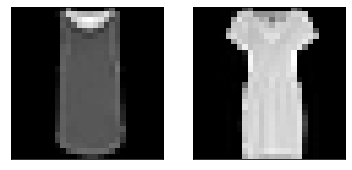

In [8]:
# Função para fazer gráfico do par
def plot_par(par, index):
    plt.figure(figsize=(6, 6))
    for i in range(2):
        plt.subplot(1, 2, 1 + i)
        plt.imshow(np.reshape(par_train[index,i], (28, 28)), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Seleciona índice do par de imagens para fazer o gráfico   
index = 3
print('Classe do par:', y_par_train[index])
plot_par(par_train, index)

## 5. Função de custo contrastante

A função de custo contrastante faz com que a distância entre duas imagens de classes diferentes aumente e que a distânica entre duas imagens de mesma classe diminua.

Essa função de custo é baseada na seguinte equação de erro definida para cada exemplo de treinamento, que consiste de um par de imagens:

$$E_C^{(i)} = y^{(i)}_{real}(D^{(i)})^2 + (1-y^{(i)}_{real}) max(M - D^{(i)}, 0)^2$$

onde $E_C^{(i)}$ é o erro para o i-ésimo par de imagens, $y^{(i)}_{real}$ é a saída real do par de imagens, $M$ é uma constante denominada margem e $D^{(i)}$ é a distância Euclidiana entre os vetores de características das duas imgens do i-ésimo par.

Nesse tipo de problema, a entrada de cada exemplo consiste de um par de imagens e a saída real consiste na classe de cada exemplo, definida por:

$$y^{(i)}_{real} = \begin{cases} 0, & para & imagens & similares \\ 1, & para & imagens & diferentes \end{cases}$$

onde $y^{(i)}_{real}$ é a classe desejada do i-ésimo exemplo e $M$ é um número positivo que representa uma margem para forçar uma distância mínima entre vetores de características de imagens similares e diferentes. 

Note que:

- Se $y^{(i)}_{real} = 0$, então, $E_C^{(i)} = max(M - D^{(i)}, 0)^2$, portanto, $E_C^{(i)} < (D^{(i)})^2$ (imagens similares)


- Se $y^{(i)}_{real} = 1$, então, $E_C^{(i)} = (D^{(i)})^2$ (imagens diferentes)

Os termos $y^{(i)}_{real}$ e $(1-y^{(i)}_{real})$ podem ser ser vistos como sendo pesos de ponderação que permitem que $(D^{(i)})^2$ ou  $max(M - D^{(i)}, 0)^2$ dominem o erro conforme a classe do par de imagens.


A função de custo contrastive é definida como sendo a média da função de erro para todos os exemplos treinamento, assim, tem-se:

$$J_C = \frac {1}{m} \sum\limits_{i=1}^{m} y^{(i)}_{real}(D^{(i)})^2 + (1-y^{(i)}_{real}) max(M - D^{(i)}, 0)^2$$

onde $J_C$ é a função de custo contrastante, que depende dos parâmetros do modelo, e $m$ é o número de exemplos.

Ressalta-se que uma função de custo do Keras recebe como entradas as saídas reais e as saídas previstas pela rede, então, para implementar essa função de custo a saída prevista pela rede siamesa deve ser a distância Euclidiana entre os vetores de características da duas imagens, ou seja:

$$y^{(i)}_{prev} = D^{(i)}$$

Dessa forma, a última camada da rede siamesa deve calcular a distância Euclidiana entre os vetores de características das duas imagens.

### Exercício #4: Função de custo contrastante na forma de classe

Implemente  na célula abaixo a função de custo contrastante na forma de classe.

Observa-se que essa função de custo espera receber como saída prevista da rede a distância Euclidiana entre os vetores de características das duas imagens.

In [9]:
""" PARA VOCÊ FAZER: Função e custo contrastante """

# Importa classe de funções de custo do Keras e Keras Backend
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

# Cria classe de função de custo customizada usando a classe "Loss" do Keras
class ContrastiveLoss(Loss):
    # define valor padrão da margem (usar 0.5)
    margin = 0.5
    
    # Função para inicializar objeto da classe
    def __init__(self, margin):
        # Comando padrão para inicializar classes do Keras
        # Inclua seu código aqui
        super().__init__()
        
        # Define delta
        # Inclua seu código aqui
        self.margin = margin
        
    # Função executada pelo objeto instanciado com a classe
    def call(self, y_true, y_pred):
        # 1o termo
        # Inclua seu código aqui
        termo1 = y_true * K.square(y_pred)
        
        # 2o termo
        # Inclua seu código aqui        
        termo2 = (1 - y_true) * K.square(K.maximum(self.margin - y_pred, 0))
        
        # Custo total
        # Inclua seu código aqui
        loss = K.mean(termo1 + termo2)
        
        return loss

Teste da função de custo contrastante.

In [10]:
# Cria lote de vetores de características 
c1 = np.ones((5,1))
c2 = 0.5*np.ones((5,1))

# Instancia ojeto da classe da função de custo
CL = ContrastiveLoss(1.0)

# Calculo custo
loss = CL(c1,c2)
print('Função de custo:', loss.numpy())

Função de custo: 0.25


**Saída esperada:**

Função de custo: 0.25

## 6. RNA de geração de características

Para gerar os vetores de características das imagens vamos utlizar uma RNA com três camadas densas com a seguinte configuração:

- Número de neurônios das camadas: 128 neurônios
- Função de ativação das camadas: ReLu
- Camadas de dropout entre a 1a e 2a camadas densas e entre a 2a e 3a camadas densas

 
### Exercício #5: Configuração da RNA de extração de características

Na célula abaixo crie a rede de acordo com a configuração desejada.

In [11]:
""" PARA VOCÊ FAZER: Criar a RNA de extração de características """

from tensorflow.keras import models
from tensorflow.keras import layers

# Função para criar rna geradora de características
def rna_carac(input_dim):
    
    model = models.Sequential()
    # Inclua seu código aqui
    #
    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    
    return model

# Dimensão da entrada 
input_dim = 784

# Cria RNA geradora dos vetores de características
rna_base = rna_carac(input_dim)

rna_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
Total params: 133,504
Trainable params: 133,504
Non-trainable params: 0
_________________________________________________________________


**Saída desejada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 128)               100480    
    _________________________________________________________________
    dropout (Dropout)            (None, 128)               0         
    _________________________________________________________________
    dense_1 (Dense)              (None, 128)               16512     
    _________________________________________________________________
    dropout_1 (Dropout)          (None, 128)               0         
    _________________________________________________________________
    dense_2 (Dense)              (None, 128)               16512     
    =================================================================
    Total params: 133,504
    Trainable params: 133,504
    Non-trainable params: 0
    _________________________________________________________________



## 7. Rede siamesa

A primeira etapa para criar a rede siamesa é criar a camada de saída que calcula a distância entre os vetores e características, obtidos pela `rna_base`criada no exercício #5.


### Exercício #6: Camada customizada para calcular distância euclidina

A `rna_base` extrai os vetores de características de cada uma das imagens do par. 

Na célula abaixo crie uma camada customizada na forma de classe para calcular a distância euclidiana entre os dois vetores de características.

A distância euclidiana entre dois vetores $v$ e $u$ é definida por:

$$ d = \sum_{i=1}^{n} (v_i - u_i)^2$$

onde $n$ é o número de elementos dos dois vetores, e $v_i$ e $u_i$ são respectivamente os i-ésimos elementos dos vetores $v$ e $u$ .

In [12]:
""" PARA VOCÊ FAZER: Camada customizada para calcular distância euclidiana """

# Importa classe de camadas do Keras
from tensorflow.keras import layers

# Define classe de camada Distance
class EuclidianDistance(layers.Layer):
    # Inicializa objeto da classe
    def __init__(self):
        # Incialização
        # Inclua seu código aqui
        #
        super().__init__()
    def euclidian_dist(self, v1, v2):
        return K.square(K.sum(K.square(v1 - v2), axis=1))
    
    # Define cálculo realizado pela camada
    def call(self, inputs):
        # Separa os dois vetores
        # Inclua seu código aqui
        v1, v2 = inputs[0], inputs[1]
        # Calcula Adiciona a entrada ao valor do estado interno da camada
        # Inclua seu código aqui
        self.add_metric(self.euclidian_dist(v1, v2), name='euclidian_distance')
        dist = self.euclidian_dist(v1, v2)
        
        return dist

Execute a célula abaixo para testar a sua camada para calcular a distância euclidiana entre dois vetores.

Nesse teste temos um lote de 5 exemplo. Assim, a saída dessa camada deve consistir de 5 distâncias.

In [13]:
# Define tensores vetores de entrada da camada
v1 = 0.9*tf.ones((5,8))
v2 = 0.8*tf.ones((5,8))

# Instância objeto da camada 
dist = EuclidianDistance()

# Calcula saída da camada
d = dist([v1, v2])

# Mostra parâmetros da camada
print('Entrada 1:', v1.numpy())
print('Entrada 2:', v2.numpy())
print('Distância entre os vetores:', d.numpy())

Entrada 1: [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]
Entrada 2: [[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]]
Distância entre os vetores: [0.00639999 0.00639999 0.00639999 0.00639999 0.00639999]


**Saída desejada:**

    Entrada 1: [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
     [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]
    Entrada 2: [[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
     [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]]
    Distância entre os vetores: [0.00639999 0.00639999 0.00639999 0.00639999 0.00639999]

### Exercício #7: Configuração da rede siamesa

A `rna_base` extrai os vetores de características de cada uma das imagens. Dessa forma, a rede siamesa é composta por duas `rna_base`, uma para cada imagem dos pares. 

A última camada da rede siamesa calcula a distância euclidiana entre os dois vetores de características, que é a saída desejada para a rede siamesa.

Na célula abaixo, crie a rede  siamesa usando a `rna_base` e a camada `EuclidianDistance`.

In [14]:
""" PARA VOCÊ FAZER: Criar a RNA siamesa """

# Instancia camada para calculo da distância euclidiana
# Inclua seu código aqui
dist = EuclidianDistance()

# Define duas camadas de entrada, uma para cada imagem do par
# Inclua seu código aqui
img1 = layers.Input(shape=(input_dim,))
img2 = layers.Input(shape=(input_dim,))

# Extração dos vetores de características das duas imagens
# Inclua seu código aqui
feature_1 = rna_base(img1)
feature_2 = rna_base(img2)

# Cálculo da distãncia euclidiana entre os vetores de características
# Inclua seu código aqui
distance = dist([feature_1, feature_2])

# Instancia rede siamensa completa
# Inclua seu código aqui
siam = models.Model([img1, img2], distance)

# Summario da rede
siam.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          133504      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
euclidian_distance_1 (Euclidian (None,)              0           sequential[0][0]             

**Saída esperada:**

    Model: "model"
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    input_1 (InputLayer)            [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    input_2 (InputLayer)            [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    sequential (Sequential)         (None, 128)          133504      input_1[0][0]                    
                                                                     input_2[0][0]                    
    __________________________________________________________________________________________________
    distance (Distance)             (None,)              0           sequential[0][0]                 
                                                                     sequential[1][0]                 
    ==================================================================================================
    Total params: 133,504
    Trainable params: 133,504
    Non-trainable params: 0
    __________________________________________________________________________________________________

Vamos avaliar a RNA não treinada para termos uma base do resultado esperado do treinamento.

In [15]:
# Calcula previsões da RNA não treinada
distances = siam.predict([par_train[:8,0], par_train[:8,1]])
print('Distancias:', distances)

# Instancia função de custo
CL = ContrastiveLoss(1.0)

# Calcula função de custo 
loss_value = CL(y_true=y_par_train[:8], y_pred=distances)
print("Custo antes do treinamento =", loss_value.numpy())

Distancias: [10.138122   16.529842   10.422146   10.421161    3.0330403  19.22396
  0.22302698  2.8072376 ]
Custo antes do treinamento = 27.581463


**Saída esperada:**

    Distancias: [27.948912  15.51055    5.7633586 34.252586   3.1170928 15.242242
      0.3146033  9.001882 ]
    Custo antes do treinamento = 103.0216

## 8. Compilação, treinamento e teste da rede siamesa


### Exercício #8: Compilação da rede 

A compilação da rede siamensa deve ser realzada da seguinte forma:
    
- Otimizador: Adam com taxa de aprendizado de 0.001
- Função de custo: Contrastante

Lembre que para realizar um treinamento customizado devemos criar objetos com o otimizador e com a função de custo.

Se quisermos utilizar uma métrica temos que criar uma customizada, pois uma métrica comum compara a saída prevista pela rede (que é distância entre os vetores de características) com a classe do par. Isso nesse problema não faria sentido.  

Use um valor de 1.0 para a margem $M$ da função de custo contrastante.

In [16]:
""" PARA VOCÊ FAZER: Compilar a RNA siamesa """

# Margem 
# Inclua seu código aqui
MARGIN = 1.

# Define objeto otimizador usando tf.keras.optimizer.Addam
# Inclua seu código aqui
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define objeto função de custo usando tf.keras.losses.BinaryCrossentropy
# Inclua seu código aqui
loss_object = ContrastiveLoss(MARGIN)

### Exercício #9: Treinamento da RNA

Para treinar a rede siamesa você deve criar um loop customizado usando a função `tf.GradientTape()`. 

Para isso crie um função que calcula o gradiente da função de custo em relação aos parâmetros da rede e depois atualiza esses parâmetros usando o otimizador configurado anteriormente.

Para acessar os parâmetros de um modelo do TensorFlow basta usar `model.trainable_weights`.

In [17]:
""" PARA VOCÊ FAZER: Função para calculo do gradiante e atualização de parâmetros """

# Função que calcula gradientes e atualiza parâmetros da RNA
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    Função para calcular o gradinet e atualizar os parâmetros da RNA
    
    Argumentos:
        optimizer: otimizador configurado para atualizar os parâmetros
        loss_object: função de custo configurada anteriormente
        model: RNA que está sendo treinada
        x: tensor com os dados de entrada de treinamento
        y: saídas desejadas dos dados de treinamento
        
    Retorna:
        logits = saídas previstas pela RNA
        loss_value = valor da função de custo
    '''
    
    with tf.GradientTape() as tape:
        # Inclua seu código aqui
        y_prev = model(x)
        loss_value = loss_object(y, y_prev)
  
    # Inclua seu código aqui
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return y_prev, loss_value

Para testar a sua função `apply_gradient` execute a célula abaixo.

In [18]:
# Executa um passo de treinamento usando 5 pares de treinamento
y_prev, loss_value = apply_gradient(optimizer, loss_object, siam, [par_train[:8,0], par_train[:8,1]], y_par_train[:8])

print('Distâncias calculadas:', y_prev.numpy())
print('Custo contrastante:', loss_value.numpy())

Distâncias calculadas: [10.138122   16.529842   10.422146   10.421161    3.0330403  19.22396
  0.22302698  2.8072376 ]
Custo contrastante: 27.581463


**Saída esperada:**

    Distâncias calculadas: [27.948912  15.51055    5.7633586 34.252586   3.1170928 15.242242
      0.3146033  9.001882 ]
    Custo contrastante: 103.02165

### Exercício #10: Cálculo do custo e métrica para os dados de validação

No final de cada época de treinamento, temos que validar a RNA no conjunto de dados de teste. Para isso é necessário criar uma função que calcula a função de custo para os dados de teste.

In [19]:
""" PARA VOCÊ FAZER: Função para calcular custo dos dados de validação """

# Função para calcular custo e métrica dos dados de validação
def perform_validation(model, x_val, y_val):
    # Calcula saídas previstas dos dados de validação
    # Inclua seu código aqui
    val_prev = model(x_val)

    #Calcula custo dos dados de validação
    # Inclua seu código aqui
    val_loss = loss_object(y_val, val_prev)

    return val_loss

Execute a célula abaixo para testar a sua função `perform_validation`.

In [20]:
# Calcula função de custo para os dados de teste
val_loss = perform_validation(siam, [par_test[:8,0], par_test[:8,1]], y_par_test[:8])

print('Custo contrastante:', val_loss.numpy())

Custo contrastante: 4.499492


**Saída eseparada:**

    Custo contrastante: 29.008701

### Exercício #11:  Loop de treinamento customizado

Usando a função `apply_gradient()` crie um loop de treinamemto customizado. Nesse loop utilize os seguintes parâmetros:

1. Número de épocas de treinamento: 50
2. Tamanho dos lotes: 857 pares

In [21]:
"""" PARA VOCÊ FAZER: Loop de treinamento customizado """

# Define número de épocas
# Inclua seu código aqui
num_epocas = 50

# Define tamanho do lote
# Inclua seu código aqui
batch_size = 857

# calcula número de lotes
# Inclua seu código aqui
n_batches = len(y_train)*2 // batch_size
print('Número de lotes:', n_batches)

# Incializa vetores de custo e métricas
train_loss = np.zeros(num_epocas)
train_accuracy = np.zeros(num_epocas)
val_loss = np.zeros(num_epocas)
val_accuracy = np.zeros(num_epocas)

# Loop de treinamento
print('\nProcesso de treinamento:')
for i in range(num_epocas):
    loss_batch = []
  
    for j in range(n_batches):
        # Determina pares de exemplos do lote
        jni = j*batch_size
        jfim = jni + batch_size

        # Aplica gradiente em um lote 
       # Inclua seu código aqui
        y_prev, loss_value = apply_gradient(optimizer, loss_object, siam, [par_train[jni:jfim, 0], par_train[jni:jfim, 1]], y_par_train[jni:jfim])
        
        # Guarda custo do lote
        # Inclua seu código aqui
        loss_batch.append(loss_value)

    # Calcula custo dos dados de treinamento
    # Inclua seu código aqui
    loss = np.mean(np.array(loss_batch))

    # Guarda valores do custo dos dados de treinamento para fazer gráfico posteriomente
    # Inclua seu código aqui
    train_loss[i] = loss
        
    # Calcula função de custo para dados de validação   
    # Inclua seu código aqui
    val_loss[i] = perform_validation(siam, [par_test[:,0], par_test[:,1]], y_par_test)

    # Imprime resultado da função de custo e métrica da época
    if i % 5 == 0:
        print('Época:', i, '-', 'custo =', train_loss[i], '-', 'custo_val =', val_loss[i])

# Imprime resultado final
print('\nCusto final =', loss)
print('Custo final de validação =', val_loss[num_epocas-1])

Número de lotes: 140

Processo de treinamento:
Época: 0 - custo = 0.5277583599090576 - custo_val = 0.5279236435890198
Época: 5 - custo = 0.15122640132904053 - custo_val = 0.14860893785953522
Época: 10 - custo = 0.10776587575674057 - custo_val = 0.1231745034456253
Época: 15 - custo = 0.09913714230060577 - custo_val = 0.12139445543289185
Época: 20 - custo = 0.08362170308828354 - custo_val = 0.1896345317363739
Época: 25 - custo = 0.08638269454240799 - custo_val = 0.12583382427692413
Época: 30 - custo = 0.07691948860883713 - custo_val = 0.13628597557544708
Época: 35 - custo = 0.0810369923710823 - custo_val = 0.15256470441818237
Época: 40 - custo = 1.3951659202575684 - custo_val = 0.2543710768222809
Época: 45 - custo = 0.2868415415287018 - custo_val = 0.29315894842147827

Custo final = 0.16319354
Custo final de validação = 0.1679939180612564


**Saída esperada:**

    Número de lotes: 140

    Processo de treinamento:
    Época: 0 - custo = 0.8560684323310852 - custo_val = 2.8116605281829834
    Época: 5 - custo = 0.1400299370288849 - custo_val = 0.1494632214307785
    Época: 10 - custo = 0.12407270073890686 - custo_val = 0.1476677805185318
    Época: 15 - custo = 0.11732614040374756 - custo_val = 0.17168080806732178
    Época: 20 - custo = 0.10116748511791229 - custo_val = 0.13356824219226837
    Época: 25 - custo = 0.09833920747041702 - custo_val = 0.13175609707832336
    Época: 30 - custo = 0.09097666293382645 - custo_val = 0.13400404155254364
    Época: 35 - custo = 0.07837433367967606 - custo_val = 0.11620257794857025
    Época: 40 - custo = 0.08293379098176956 - custo_val = 0.15984424948692322
    Época: 45 - custo = 0.08584948629140854 - custo_val = 0.1398329734802246

    Custo final = 0.07904582
    Custo final de validação = 0.10712108761072159

Gráfico do processo de treinamento.

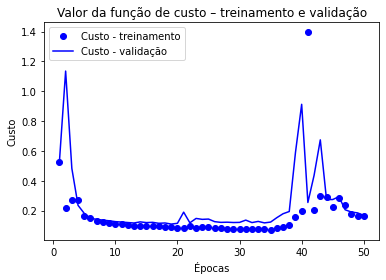

In [22]:
# Cria vetor de épocas
epocas = range(1, num_epocas + 1)

# Gráfico dos valores de custo
plt.plot(epocas, train_loss, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_loss, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

### Exercício #12: Teste da rede siamesa

Para testar a rede siamesa vamos calcular as distâncias entre os vetores de varacterísticas das imagens dos pares de teste. 

Considere que as imagens são iguais se a distância for menor do que $0.5M$ e diferentes se a distância for maior do que $0.5M$. Assim, identifique os pares de teste da seguinte forma:

1. Se a distância <= M/2, então, as imagens são similares e y_prev = 1
2. Se a distância > M/2, então, as imagens são diferentes e y_prev = 0

In [23]:
""" PARA VOCÊ FAZER: Cálculo das classes dos pares de teste """

# Calcula saída prevista para os dados de teste
# Inclua seu código aqui
distances = siam.predict([par_test[:,0], par_test[:,1]])

# Inicilaiza saídas previstas de teste
y_prev_test = np.zeros(len(distances))

# Identifica as classes previstas
for i in range(len(distances)):
    # Inclua seu código aqui
    if distances[i] <= MARGIN/2:
        y_prev_test[i] = 1
    else:
        y_prev_test[i] = 0

print('Distancias dos primeiros 10 exemplos:', distances[:10].T)
print('Classes reais dos primeiros 10 exemplos:', y_par_test[:10].T)
print('Classes previstas dos primeiros 10 exemplos:', y_prev_test[:10])

Distancias dos primeiros 10 exemplos: [7.81071931e-02 4.23676205e+00 6.28199801e-02 1.88531041e+00
 5.16354048e-04 7.40102053e+00 2.31447048e-03 2.99803329e+00
 1.11081496e-01 3.18127298e+00]
Classes reais dos primeiros 10 exemplos: [1 0 1 0 1 0 1 0 1 0]
Classes previstas dos primeiros 10 exemplos: [1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


**Saída prevista:**

    Distancias dos primeiros 10 exemplos: [3.94202352e-01 5.61574125e+00 3.79724354e-01 3.30952913e-01
     1.63637334e-03 2.52436590e+00 5.02530253e-03 9.90402177e-02
     1.02814764e-01 5.74189901e-01]
    Classes reais dos primeiros 10 exemplos: [1 0 1 0 1 0 1 0 1 0]
    Classes previstas dos primeiros 10 exemplos: [1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
    
    
Execute a célula abaixo para calcular a exatidão da classificação dos pares de imagens de teste.

In [24]:
# Calculo da extidão dos dados de treinamento e teste          
exatidao = 1 - np.mean(np.abs(y_par_test-y_prev_test))
                       
print('Exatidão:', exatidao)

Exatidão: 0.8242742742742742


**Saída prevista:**

    Exatidão: 0.8809309309309309

#### Execute a célula abaixo para visualizar o desempenho da sua rede siamensa nos pares de teste

Observe que cada bolinha azul é um erro de previsão da classe do par.

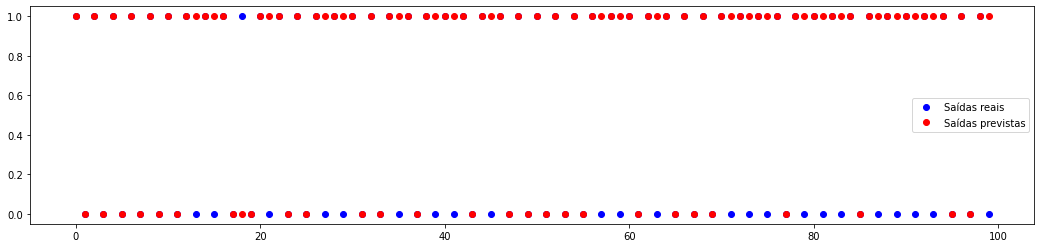

In [25]:
# verificação dos 200 primeiros exemplos de teste 
plt.figure(figsize=(18,4))
plt.plot(y_par_test[:100], 'bo', label='Saídas reais')
plt.plot(y_prev_test[:100], 'ro', label='Saídas previstas')
plt.legend()
plt.show()

## 9. Conclusão

Uma exatidão de 88% nos dados de teste não é um resultado bom, mas também não é um resultado muito ruim. 

Certamente esse resultado pode ser melhorando por meio de um ajuste dos hiper parâmetros do modelo, tais como:

1. Alteração do número de camdas, do número de neurônios e da função de ativação das camadas da rede de extração de características.

2. Alteração da margem da função de custo contrastante.

3. Alteração da taxa de dropout.

4. Inclusão de regularização L1 ou L2.

## Tuning de Hiper parâmetros
Para a melhoria do desempenho da rede será realizado um GridSearch com os a grid definida a seguir

#### Helper functions

In [26]:
from plotly import graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots
from plotly.io import to_html
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Função para criar rna geradora de características
def build_model(units, dropout):
    # Instancia camada para calculo da distância euclidiana
    # Inclua seu código aqui
    dist = EuclidianDistance()

    # Define duas camadas de entrada, uma para cada imagem do par
    # Inclua seu código aqui
    img1 = layers.Input(shape=(784,))
    img2 = layers.Input(shape=(784,))

    rna_base = models.Sequential()
    
    for i in range(len(units)):
        rna_base.add(layers.Dense(units[i], activation='relu', input_shape=(784,)))
        if not i == (len(units)-1):
            rna_base.add(layers.Dropout(dropout))

        
    # Extração dos vetores de características das duas imagens
    # Inclua seu código aqui
    feature_1 = rna_base(img1)
    feature_2 = rna_base(img2)

    # Cálculo da distãncia euclidiana entre os vetores de características
    # Inclua seu código aqui
    distance = dist([feature_1, feature_2])

    # Instancia rede siamensa completa
    # Inclua seu código aqui
    model = models.Model([img1, img2], distance)
    
    return model

def calculate_acc(model, pars, y_pars, margin):
    distances = model.predict([pars[:,0], pars[:,1]])

    # Inicilaiza saídas previstas de teste
    y_prev = np.zeros(len(distances))

    # Identifica as classes previstas
    for i in range(len(distances)):
        # Inclua seu código aqui
        if distances[i] <= margin/2:
            y_prev[i] = 1
        else:
            y_prev[i] = 0

        # Guarda custo do lote
    # Inclua seu código aqui
    acc_value = 1 - np.mean(np.abs(y_pars-y_prev))

    return acc_value


def train_model(model, batch_size, learning_rate, margin):
    
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_object = ContrastiveLoss(margin)
    
    num_epocas = 20
    batch_size = batch_size

    n_batches = len(y_train)*2 // batch_size

    train_loss = np.zeros(num_epocas)
    train_accuracy = np.zeros(num_epocas)
    val_loss = np.zeros(num_epocas)
    val_accuracy = np.zeros(num_epocas)

    # Loop de treinamento
    for i in range(num_epocas):
        loss_batch = []
        acc_batch = []

        for j in range(n_batches):
            # Determina pares de exemplos do lote

            jni = j*batch_size
            jfim = jni + batch_size

            # Aplica gradiente em um lote 
            # Inclua seu código aqui
            y_prev, loss_value = apply_gradient(optimizer, loss_object, model, [par_train[jni:jfim, 0], par_train[jni:jfim, 1]], y_par_train[jni:jfim])
            
            acc_value = calculate_acc(model, par_train[jni:jfim], y_par_train[jni:jfim], margin)
            
            loss_batch.append(loss_value)
            acc_batch.append(acc_value)

            

        # Calcula custo dos dados de treinamento
        # Inclua seu código aqui
        loss = np.mean(np.array(loss_batch))
        acc = np.mean(np.array(acc_batch))

        # Guarda valores do custo dos dados de treinamento para fazer gráfico posteriomente
        # Inclua seu código aqui
        train_loss[i] = loss
        train_accuracy[i] = acc

        # Calcula função de custo para dados de validação   
        # Inclua seu código aqui
        val_loss[i] = perform_validation(model, [par_test[:, 0],par_test[:, 1]], y_par_test)
        val_accuracy[i] = calculate_acc(model, par_test, y_par_test, margin)
        
            
    history = {
        "loss":train_loss,
        "val_loss":val_loss,
        "accuracy":train_accuracy,
        "val_accuracy":val_accuracy
    }
    return history
    

def plot_results(historia):

    dic_historia = historia  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    perda_treino = dic_historia['loss']
    perda_valid = dic_historia['val_loss']

    acuracia_treino = dic_historia['accuracy'] 
    acuracia_valid = dic_historia['val_accuracy']
    epocas = range(1, len(acuracia_treino) + 1)
    tmp = pd.DataFrame({
        "Epocas":epocas,
        "Acurácia_Treino":acuracia_treino,
        "Acurácia_Validação":acuracia_valid,
        "Custo_Treino":perda_treino,
        "Custo_Validação":perda_valid,
    })

    fig = make_subplots(rows=2, cols=1,
        subplot_titles=("Acurácia por Épocas", "Custo por Épocas"))

    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Acurácia_Validação"],
            name="Acurácia Validação",
            mode='lines+markers'
        ),
        row=1,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Acurácia_Treino"],
            name="Acurácia Treino",
            mode='lines+markers'
        ),
        row=1,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Custo_Validação"],
            name="Custo Validação",
            mode='lines+markers'
        ),
        row=2,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Custo_Treino"],
            name="Custo Treino",
            mode='lines+markers'
        ),
        row=2,
        col=1
    )
    fig.update_xaxes(title_text="Épocas", row=1, col=1)
    fig.update_xaxes(title_text="Épocas", row=2, col=1)
    fig.update_yaxes(title_text="Acurácia", row=1, col=1, range=[0, 1])
    fig.update_yaxes(title_text="Custo", row=2, col=1, range=[0, 1])
    fig.update_layout(height=1200, width=800)
    fig_html = to_html(fig, full_html=False)
    return fig_html

def build_report(historia, hiperparams, modelo, first_run=False, last_run=False):
    if first_run:
        fl = open("tuning-process-report.html", 'w')
        fl.write("""
        <html>
            <head>
                <meta charset="UTF-8">
                <style>
                .plotly-graph-div {
                    margin: 0 auto;
                }
                </style>
            </head>
            <body>
                <h1 align=\'center\'>Report do processo de busca do melhor modelo</h1>
                <hr>
        """)
    else:
        fl = open('tuning-process-report.html', 'a')
        fl.write("<hr>")

    fl.write("""
    <h2 align=\'center\'>Hiper parâmetros do modelo</h2>
    <div align=\'center\'>
    """)
    for hiperparam in hiperparams:
        fl.write(str(hiperparam) + ": " + str(hiperparams[hiperparam]) + "<br>")
    
    fl.write(f'''
    Acurácia na avaliação: {str(historia["val_accuracy"][-1])} <br>
    Perda: {str(historia["val_loss"][-1])}
    </div>
    ''')
    fig_html = plot_results(historia)
    fl.write(fig_html)
    if last_run:
        fl.write("""
        </body>
        </html>        
        """)
    fl.close()
    return historia["val_accuracy"][-1]
    

In [28]:

hiperparams_grid = {
    "units":[[128, 128, 128], [8, 8, 8, 8, 8, 8, 8, 8], [128, 64, 8]],
    "learning_rate":[0.001, 0.01],
    "batch_size":[857],
    "dropout":[0.1, 0.3, 0.7],
    "margin":[0.8, 1.]
}

In [ ]:
first_run = True
last_run = False
max_runs = 1
best_acc = 0
n = 0

for f in hiperparams_grid:
    max_runs *= len(hiperparams_grid[f])
    max_runs_helper = max_runs

for h_units in hiperparams_grid["units"]:
    for h_learning_rate in hiperparams_grid["learning_rate"]:
        for h_dropout in hiperparams_grid['dropout']:
            for h_batch in hiperparams_grid["batch_size"]:
                for h_margin in hiperparams_grid['margin']:
                    if max_runs == 1:
                        last_run=True
                    modelo = build_model(h_units, h_dropout)
                    historia = train_model(modelo, h_batch, h_learning_rate, h_margin)
                    print(str(n+1), 'out of', max_runs_helper)
                    current_acc = build_report(historia,
                                 {"units":h_units, "learning_rate":h_learning_rate, "batch":h_batch, "dropout":h_dropout, "margin":h_margin}, 
                                 modelo, first_run, last_run)
                    
                    if current_acc > best_acc:
                        best_acc = current_acc
                        print(f"New best ACC {round(best_acc*100, 2)} using {h_units, h_learning_rate, h_batch, h_dropout, h_margin}")
                        modelo.save('best_siam_model')
                    first_run=False
                    max_runs-=1
                    n += 1


1 out of 36
New best ACC 85.14 using ([128, 128, 128], 0.001, 857, 0.1, 0.8)
INFO:tensorflow:Assets written to: best_siam_model/assets
2 out of 36
New best ACC 86.75 using ([128, 128, 128], 0.001, 857, 0.1, 1.0)
INFO:tensorflow:Assets written to: best_siam_model/assets
3 out of 36
4 out of 36
5 out of 36
6 out of 36
7 out of 36
8 out of 36
9 out of 36
10 out of 36
11 out of 36
12 out of 36
13 out of 36
14 out of 36
15 out of 36
16 out of 36
17 out of 36
18 out of 36
19 out of 36
20 out of 36
21 out of 36
22 out of 36
23 out of 36
